In [1]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict, namedtuple
from functools import partial
from typing import Any, Callable, Dict, List

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from src import (
    ComplexNN,
    SimpleNN,
    TrainResult,
    eval_model,
    eval_per_class_accuracy,
    freq_entropy,
    generate_even_frequency,
    generate_frequency_list,
    generate_multivariate_gaussian_data,
    generate_seperable_data,
    make_data_test_err_plot,
    make_pca_plot,
    max_entropy,
    milLoss,
    plot_compare_test_error,
    prob_entropy,
    train,
)
from torch.utils.data import DataLoader, TensorDataset

# Generate Synthetic Data

-----Train Data-----
torch.Size([870, 5])
-----Test Data-----
torch.Size([1000, 5])


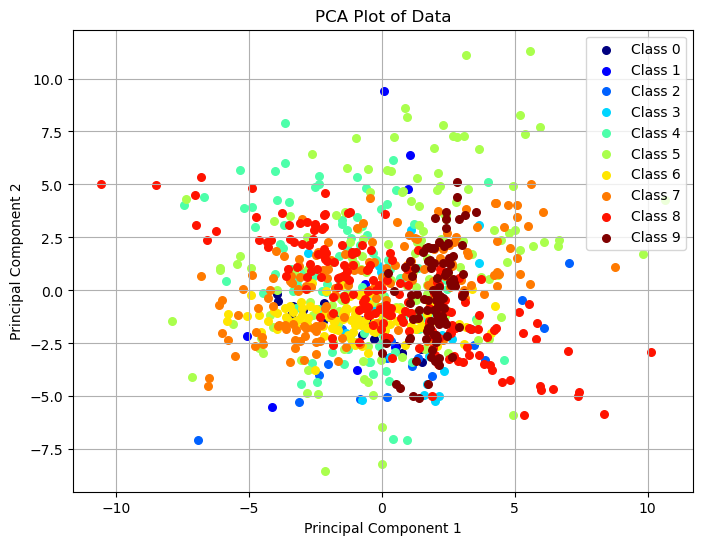

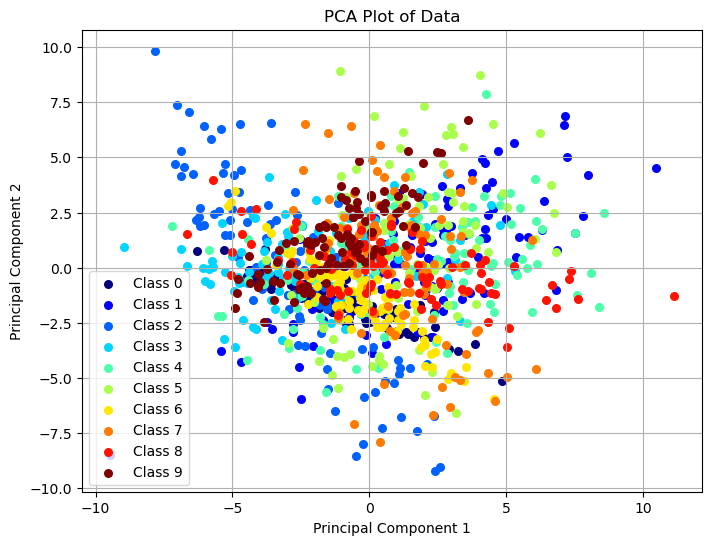

In [2]:
num_classes = 10
data_dim = 5

# train_class_balance = [100] * num_classes
train_class_balance = [2 * v for v in [10, 5, 10, 10, 50, 80, 50, 80, 90, 50]]
train_dataset, class_distributions = generate_multivariate_gaussian_data(
    train_class_balance, num_classes, data_dim
)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

test_class_balance = [100] * num_classes
test_dataset, test_distributions = generate_multivariate_gaussian_data(
    test_class_balance, num_classes, data_dim, class_distributions
)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

print("-----Train Data-----")
print(train_dataset.tensors[0].shape)
make_pca_plot(*train_dataset.tensors)

print("-----Test Data-----")
print(test_dataset.tensors[0].shape)
make_pca_plot(*test_dataset.tensors)

torch.Size([1000, 5])


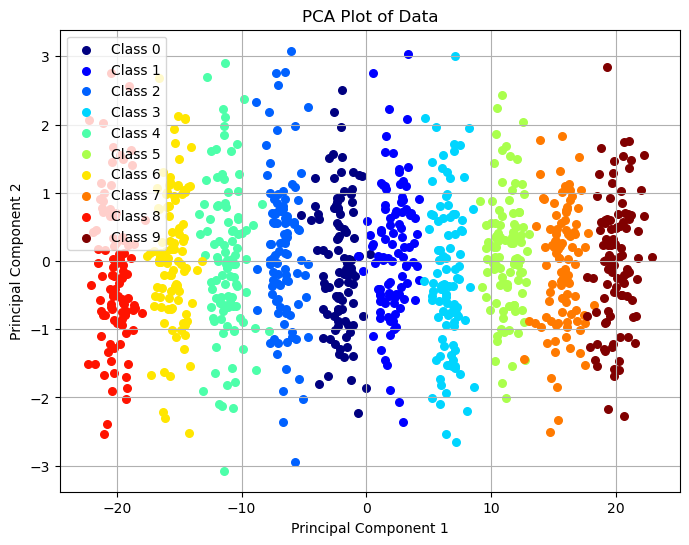

In [3]:
num_classes = 10
data_dim = 5

class_balance = generate_even_frequency(num_classes)
dataset, _ = generate_seperable_data(class_balance, num_classes, data_dim)

print(dataset.tensors[0].shape)
make_pca_plot(*dataset.tensors)

# Training

In [4]:
def plot_acc_loss(hist):
    # Create a figure with three subplots in a 1x3 grid
    rows, cols = 1, 2
    fig, (ax1, ax2) = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))

    # Plot Training Loss
    ax1.plot(hist["epoch"], hist["loss"])

    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Epochs")
    ax1.set_title("Training Loss vs. Epochs")

    # Plot Training Accuracy
    ax2.plot(hist["epoch"], hist["train_acc"], label="train_acc")
    ax2.plot(hist["epoch"], hist["test_acc"], label="test_acc")

    ax2.set_ylabel("Accuracy %")
    ax2.set_xlabel("Epochs")
    ax2.set_title("Training/Test Acc vs. Epochs")
    ax2.legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()


def train_cel_model(epochs, data_dim, num_classes, train_loader, test_loader):
    cel_model = ComplexNN(data_dim, num_classes, 4, 40)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cel_model.parameters(), lr=0.001)

    cel_hist = train(
        cel_model,
        train_loader,
        criterion,
        optimizer,
        epochs=epochs,
        test_loader=test_loader,
    )
    return cel_model, cel_hist


def train_mil_model(
    epochs, data_dim, num_classes, train_loader, test_loader, lambda_reg=0.5, lr=1e-3
):
    # Initialize the model, loss function, and optimizer
    model = ComplexNN(data_dim, num_classes, 2, 40)
    criterion = partial(milLoss, lambda_reg=lambda_reg)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    mil_hist = train(
        model,
        train_loader,
        criterion,
        optimizer,
        epochs=epochs,
        test_loader=test_loader,
    )
    return model, mil_hist

# Synthetic Data Classification

In [5]:
num_classes = 15
data_dim = 10
# target_entropy = max_entropy(num_classes)
target_entropy = 2

train_total = 1500
test_total = 1000

# Generate Train Data
train_class_balance = generate_frequency_list(
    num_classes, target_entropy, total_count=train_total
)
train_dataset, class_distributions = generate_multivariate_gaussian_data(
    train_class_balance, num_classes, data_dim
)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
print(
    f"\n----Label Entropy {freq_entropy(train_class_balance)} - ClassFreq: {train_class_balance}----"
)

# Generate Test Data
test_class_balance = [int(test_total / num_classes)] * num_classes
test_dataset, test_distributions = generate_multivariate_gaussian_data(
    test_class_balance, num_classes, data_dim, class_distributions
)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

# Fit CEL Model
print("CEL")
cel_model, cel_hist = train_cel_model(
    100, data_dim, num_classes, train_loader, test_loader
)

# Fit MIL Model
print("MIL")
mil_model, mil_hist = train_mil_model(
    100, data_dim, num_classes, train_loader, test_loader, lambda_reg=4
)
t = TrainResult(
    target_entropy,
    train_class_balance,
    train_dataset,
    test_dataset,
    cel_model,
    mil_model,
    cel_hist,
    mil_hist,
)


----Label Entropy 1.980351795340379 - ClassFreq: [48, 19, 1043, 16, 18, 29, 44, 48, 15, 34, 15, 19, 52, 37, 54]----
CEL
Training on device: cpu
Epoch 0,   Loss:244.09,   Train_Acc: 69.35%,   Test_Acc: 6.67 %
Epoch 10,   Loss:86.06,   Train_Acc: 81.42%,   Test_Acc: 28.48 %
Epoch 20,   Loss:54.87,   Train_Acc: 87.93%,   Test_Acc: 34.04 %
Epoch 30,   Loss:27.29,   Train_Acc: 94.03%,   Test_Acc: 35.86 %
Epoch 40,   Loss:10.93,   Train_Acc: 97.85%,   Test_Acc: 38.69 %
Epoch 50,   Loss:4.32,   Train_Acc: 99.53%,   Test_Acc: 40.61 %
Epoch 60,   Loss:7.11,   Train_Acc: 98.79%,   Test_Acc: 40.40 %
Epoch 70,   Loss:0.55,   Train_Acc: 100.00%,   Test_Acc: 40.20 %
Epoch 80,   Loss:0.20,   Train_Acc: 100.00%,   Test_Acc: 39.19 %
Epoch 90,   Loss:5.84,   Train_Acc: 98.73%,   Test_Acc: 37.58 %
MIL
Training on device: cpu
Epoch 0,   Loss:768.36,   Train_Acc: 67.54%,   Test_Acc: 6.67 %
Epoch 10,   Loss:289.03,   Train_Acc: 70.09%,   Test_Acc: 6.67 %
Epoch 20,   Loss:225.41,   Train_Acc: 73.57%,   Test

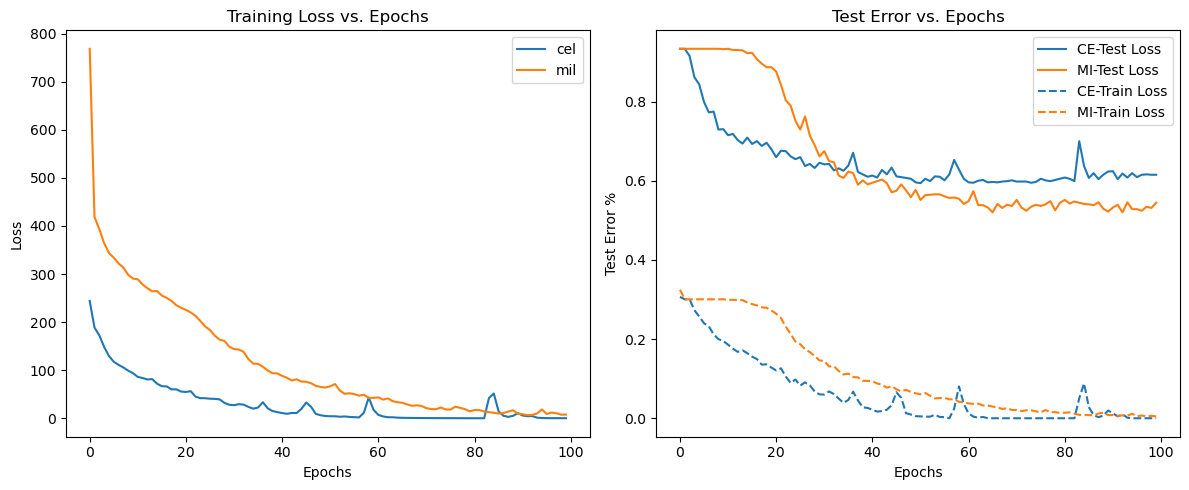

In [6]:
# Create a figure with three subplots in a 1x3 grid
rows, cols = 1, 2
fig, (ax1, ax2) = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))

# Plot Training Loss
ax1.plot(cel_hist["epoch"], cel_hist["loss"], label="cel")
ax1.plot(mil_hist["epoch"], mil_hist["loss"], label="mil")
ax1.set_ylabel("Loss")
ax1.set_xlabel("Epochs")
ax1.set_title("Training Loss vs. Epochs")
ax1.legend()

# Test Error vs Epoch
plot_compare_test_error(cel_hist, mil_hist, ax2)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [7]:
# acc, cel_per_class_acc = eval_per_class_accuracy(cel_model, test_loader, num_classes)
# print(cel_per_class_acc)
# plt.bar(range(len(cel_per_class_acc)), cel_per_class_acc)

## Easily Separable Dataset

In [8]:
num_classes = 15
data_dim = 8
# target_entropy = max_entropy(num_classes)
target_entropy = 2

train_total = 1000
test_total = 1000

# Generate Train Data
train_class_balance = generate_frequency_list(
    num_classes, target_entropy, total_count=train_total
)
train_dataset, class_distributions = generate_seperable_data(
    train_class_balance, num_classes, data_dim
)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
print(
    f"\n----Label Entropy {freq_entropy(train_class_balance)} - ClassFreq: {train_class_balance}----"
)

# Generate Test Data
test_class_balance = [int(test_total / num_classes)] * num_classes
test_dataset, test_distributions = generate_multivariate_gaussian_data(
    test_class_balance, num_classes, data_dim, class_distributions
)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

# Fit CEL Model
print("CEL")
cel_model, cel_hist = train_cel_model(
    100, data_dim, num_classes, train_loader, test_loader
)

# Fit MIL Model
print("MIL")
mil_model, mil_hist = train_mil_model(
    100, data_dim, num_classes, train_loader, test_loader, lambda_reg=2
)
r = TrainResult(
    target_entropy,
    train_class_balance,
    train_dataset,
    test_dataset,
    cel_model,
    mil_model,
    cel_hist,
    mil_hist,
)


----Label Entropy 1.970697918740247 - ClassFreq: [55, 9, 47, 21, 36, 15, 0, 15, 9, 3, 13, 41, 27, 680, 22]----
CEL
Training on device: cpu
Epoch 0,   Loss:130.69,   Train_Acc: 65.06%,   Test_Acc: 18.89 %
Epoch 10,   Loss:28.06,   Train_Acc: 90.23%,   Test_Acc: 54.75 %
Epoch 20,   Loss:25.46,   Train_Acc: 90.53%,   Test_Acc: 45.86 %
Epoch 30,   Loss:21.62,   Train_Acc: 93.25%,   Test_Acc: 68.48 %
Epoch 40,   Loss:9.78,   Train_Acc: 96.78%,   Test_Acc: 68.89 %
Epoch 50,   Loss:18.16,   Train_Acc: 92.85%,   Test_Acc: 61.01 %
Epoch 60,   Loss:13.66,   Train_Acc: 95.27%,   Test_Acc: 86.26 %
Epoch 70,   Loss:15.54,   Train_Acc: 93.76%,   Test_Acc: 68.38 %
Epoch 80,   Loss:8.21,   Train_Acc: 97.08%,   Test_Acc: 81.31 %
Epoch 90,   Loss:6.59,   Train_Acc: 97.48%,   Test_Acc: 79.19 %
MIL
Training on device: cpu
Epoch 0,   Loss:270.05,   Train_Acc: 67.17%,   Test_Acc: 6.67 %
Epoch 10,   Loss:68.89,   Train_Acc: 87.11%,   Test_Acc: 41.92 %
Epoch 20,   Loss:51.84,   Train_Acc: 90.53%,   Test_Acc:

In [9]:
print("MIL")
mil_model, mil_hist = train_mil_model(
    100, data_dim, num_classes, train_loader, test_loader, lambda_reg=2
)

MIL
Training on device: cpu
Epoch 0,   Loss:286.29,   Train_Acc: 68.38%,   Test_Acc: 13.33 %
Epoch 10,   Loss:74.14,   Train_Acc: 86.30%,   Test_Acc: 39.70 %
Epoch 20,   Loss:57.55,   Train_Acc: 90.43%,   Test_Acc: 57.68 %
Epoch 30,   Loss:47.57,   Train_Acc: 90.84%,   Test_Acc: 71.52 %
Epoch 40,   Loss:25.19,   Train_Acc: 95.57%,   Test_Acc: 72.12 %
Epoch 50,   Loss:30.39,   Train_Acc: 95.67%,   Test_Acc: 72.12 %
Epoch 60,   Loss:23.23,   Train_Acc: 96.17%,   Test_Acc: 81.62 %
Epoch 70,   Loss:20.68,   Train_Acc: 96.88%,   Test_Acc: 81.52 %
Epoch 80,   Loss:19.98,   Train_Acc: 96.68%,   Test_Acc: 82.53 %
Epoch 90,   Loss:34.51,   Train_Acc: 94.16%,   Test_Acc: 80.10 %


1.970697918740247


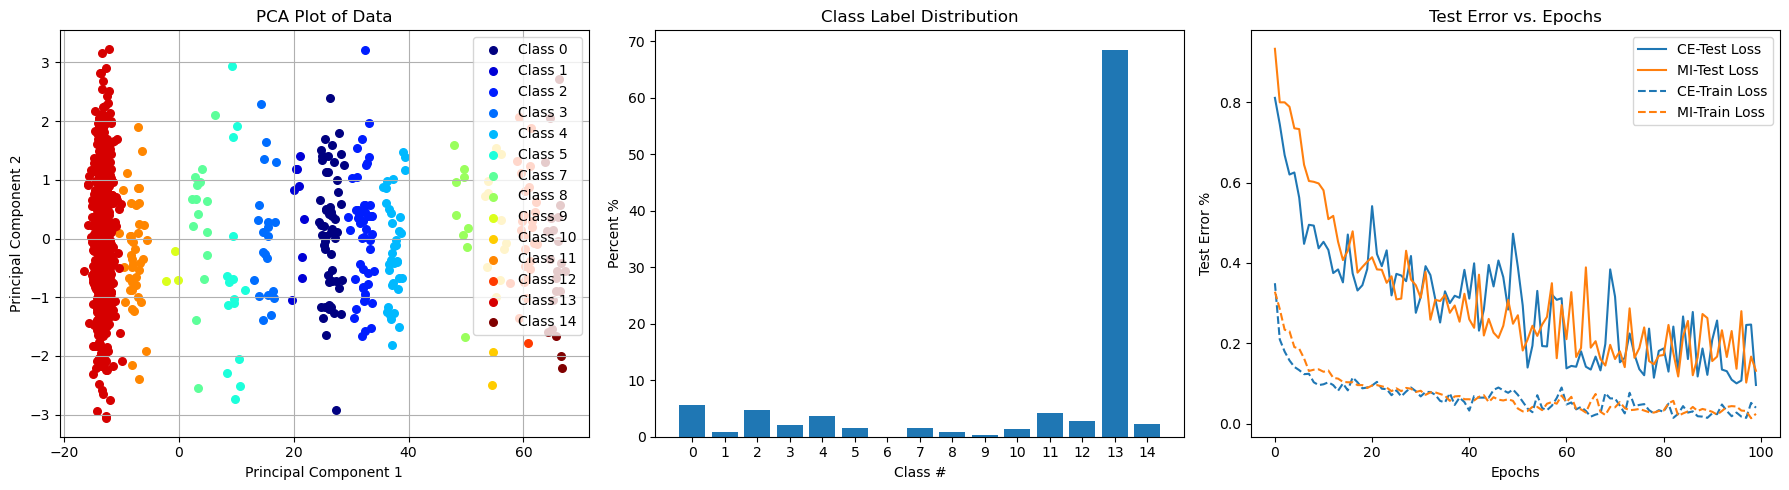

In [10]:
print(freq_entropy(r.train_class_balance))
make_data_test_err_plot(num_classes, r.train_dataset, r.cel_hist, r.mil_hist)

In [11]:
np.log2(15)

3.9068905956085187

In [12]:
---

SyntaxError: invalid syntax (1947214667.py, line 1)

# Sweep Class Label Entropy

In [ ]:
%%time

esweep = {}
data_dim = 8
num_classes = 15

for target_entropy in np.arange(1.5, max_entropy(num_classes) + 0.4, 0.25):
    # Generate data
    train_class_balance = generate_frequency_list(
        num_classes, target_entropy, total_count=2000
    )
    train_dataset, class_distributions = generate_multivariate_gaussian_data(
        train_class_balance, num_classes, data_dim
    )
    train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
    print(
        f"\n----Label Entropy {freq_entropy(train_class_balance)} - ClassFreq: {train_class_balance}----"
    )

    test_total = 1000
    test_class_balance = [int(test_total / num_classes)] * num_classes
    test_dataset, test_distributions = generate_multivariate_gaussian_data(
        test_class_balance, num_classes, data_dim, class_distributions
    )
    test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

    # Fit models
    print("CEL")
    cel_model, cel_hist = train_cel_model(
        100, data_dim, num_classes, train_loader, test_loader
    )
    print("MIL")
    mil_model, mil_hist = train_mil_model(
        100, data_dim, num_classes, train_loader, test_loader, lambda_reg=2
    )
    esweep[target_entropy] = TrainResult(
        target_entropy,
        train_class_balance,
        train_dataset,
        test_dataset,
        cel_model,
        mil_model,
        cel_hist,
        mil_hist,
    )

In [ ]:
esweep.keys()

In [ ]:
# Create a figure with three subplots in a 1x3 grid

res = esweep[1.5]
# print(f"{res.target_entropy}")
make_data_test_err_plot(num_classes, res.train_dataset, res.cel_hist, res.mil_hist)

res = esweep[3.5]
# print(f"{res.target_entropy}")
make_data_test_err_plot(num_classes, res.train_dataset, res.cel_hist, res.mil_hist)

res = esweep[4]
# print(f"{res.target_entropy}")
make_data_test_err_plot(num_classes, res.train_dataset, res.cel_hist, res.mil_hist)

In [ ]:
# SweepResult(
#     target_entropy, train_class_balance, train_dataset, test_dataset, cel_model, mil_model, cel_hist, mil_hist
# )

# 8 Features, 15 Class classificaiton
entropy_lst = []
cel_test_err = []
mil_test_err = []
for result in list(esweep.values()):
    # print(f"----{result.target_entropy}----")
    entropy_lst.append(result.target_entropy)
    cel_test_err.append(1 - result.cel_hist["test_acc"][-1])
    mil_test_err.append(1 - result.mil_hist["test_acc"][-1])

plt.plot(entropy_lst, cel_test_err, label="Cross Entropy Loss")
plt.plot(entropy_lst, mil_test_err, label="MI Loss")

plt.title(f"Test Error vs. Label Entropy ({data_dim} Features/{num_classes} Classes)")
plt.xlabel("Label Entropy")
plt.ylabel("Test Error %")
plt.legend()
plt.show()

# MI Estimator

## Monte Carlo with True Distribution

In [ ]:
%%time
# normal_dists, class_balance
x, y = test_dataset.tensors

counts = y.bincount()
p_y_marg = counts.float() / y.size(0)
mutual_info = 0

for data_point, label in test_dataset:
    p_x_marg = 0
    for class_idx in range(class_num):
        distribution = normal_dists[class_idx]
        true_prob_x_given_y = torch.exp(distribution.log_prob(data_point))
        p_x_marg += p_y_marg[class_idx] * true_prob_x_given_y

    class_label = label.cpu().item()
    class_distribution = normal_dists[class_label]
    true_prob_x_given_y = torch.exp(class_distribution.log_prob(data_point))
    joint_x_y = true_prob_x_given_y * p_y_marg[class_label]

    mutual_info += joint_x_y * np.log(true_prob_x_given_y / p_x_marg)

mutual_info

## Model Estimate Using Paper

In [ ]:
%%time
import torch.nn.functional as F

x, y = test_dataset.tensors
counts = y.bincount()
p_y_marg = counts.float() / y.size(0)

with torch.no_grad():
    model_output = F.softmax(model(x), dim=1)

N = x.shape[0]
num_classes = model_output.shape[1]

Q_y = torch.zeros(num_classes)
for i in range(num_classes):
    indicator = (y == i).float()
    Q_y[i] = torch.sum(indicator * model_output[:, i]) / N

h_y = -np.sum(p_y_marg.numpy() * np.log(Q_y.numpy()))


Q_y_given_x = model_output


p_hat_y_given_x = F.one_hot(y, num_classes=num_classes).float()

# Calculate the cross-entropy
# Since we're treating Q(y|x) as probabilities, we need to use torch.log() on these values
# and we need to be careful with zero probabilities
eps = 1e-8  # Adding a small epsilon to avoid log(0)
cross_entropy_loss = -torch.sum(
    p_hat_y_given_x * torch.log(Q_y_given_x + eps)
) / x.size(0)

cross_entropy_loss, h_y


# mutual_info = 0

# for data_point, label in test_dataset:
#     kde_estimate = np.exp(kde.score_samples([data_point.numpy()]))
#     with torch.no_grad():
#         learned_y_given_x = torch.softmax(model(data_point), dim=-1)

#     y_given_x_point = learned_y_given_x[label]
#     learned_joint_x_y = y_given_x_point * kde_estimate
#     p_y_marg_point = p_y_marg[label]

#     mutual_info += learned_joint_x_y * np.log(y_given_x_point  / p_y_marg_point)

# mutual_info

In [ ]:
model_output

In [ ]:
p_y_marg

## Model Estimate Using KDE

In [ ]:
%%time

x, y = test_dataset.tensors
counts = y.bincount()
p_y_marg = counts.float() / y.size(0)
mutual_info = 0

px_density = {}

from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel="gaussian", bandwidth=0.5)
kde.fit(x.numpy())

for data_point, label in test_dataset:
    kde_estimate = np.exp(kde.score_samples([data_point.numpy()]))
    with torch.no_grad():
        learned_y_given_x = torch.softmax(model(data_point), dim=-1)

    y_given_x_point = learned_y_given_x[label]
    learned_joint_x_y = y_given_x_point * kde_estimate
    p_y_marg_point = p_y_marg[label]

    mutual_info += learned_joint_x_y * np.log(y_given_x_point / p_y_marg_point)

mutual_info

# Scratch

In [ ]:
# Parameters for synthetic data
n_classes = 5
n_features = 5
n_samples_per_class = 100

# Generate synthetic data using multivariate Gaussian
np.random.seed(0)
data = []
labels = []

# Generate data for each class
for i in range(n_classes):
    # Generate random mean and covariance matrix
    mean = np.random.rand(n_features) * 10
    cov = np.eye(n_features) * np.random.rand(n_features)
    class_data = np.random.multivariate_normal(mean, cov, n_samples_per_class)
    class_labels = np.array([i for _ in range(n_samples_per_class)])
    data.append(class_data)
    labels.append(class_labels)

data = np.concatenate(data, axis=0)
labels = np.concatenate(labels, axis=0)

# Convert to PyTorch tensors
data_tensor = torch.Tensor(data)
labels_tensor = torch.LongTensor(labels)

# Create datasets and dataloaders
dataset = TensorDataset(data_tensor, labels_tensor)
train_set, test_set = torch.utils.data.random_split(
    dataset, [int(len(dataset) * 0.8), int(len(dataset) * 0.2)]
)
train_loader = DataLoader(train_set, batch_size=10, shuffle=True)
test_loader = DataLoader(test_set, batch_size=10, shuffle=False)


# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc = nn.Linear(n_features, n_classes)

    def forward(self, x):
        x = self.fc(x)
        return x


# Initialize the model, loss function, and optimizer
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_epochs = 300
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        import pdb

        pdb.set_trace()
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {total_loss/len(train_loader)}")

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")